### Import libraries

In [14]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 

from xgboost import XGBClassifier

# import own modules
sys.path.append("..")  # Adds higher directory to python modules path.
from scripts import features as ft
from scripts import preprocessing as pp
from scripts import evaluate_models as em

#plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

import pickle

---
## Preparations

### Load the CSV into a Dataframe

- load csv (or calculate again if not in data folder)
- update index=id
- drop useless columns
- find numerical & object columns

In [2]:
# path to csv file
path_df = os.path.join("..", "data", "df_deepgaze2e.csv")

# get features - or recalculate
recalculate_df = False
if os.path.isfile(path_df) and not recalculate_df:
    df = pd.read_csv(path_df)
else:
    df = ft.get_features()
    df.to_csv(path_df, index=False)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(
    columns=[col for col in df.columns if "_obj" in col]
)  # drop 'object' columns

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### First, drop instances & features

- unusual long fixation durations are identified as outliers and dropped
  - drop if "dur > 5000 ms"
- drop `sal_first_above_0.75*max_rank` & `sal_first_above_0.9*max_rank` since this features consists of mainly (33% / 61%) outlier values
  - outliers are coded as "20" 


In [3]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]
df = df.drop(columns=['sal_first_above_0.75*max_rank', 'sal_first_above_0.9*max_rank'])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 32 columns
 -> there are 32 numerical columns
 -> there are 0 categoricals columns


### Checking for highly correlated columns
think after running this lines, which column to additionally drop

Correlation between sp_fix_duration_ms_total and sal_weighted_duration_sum is 0.828
Correlation between sp_fix_duration_ms_mean and sal_weighted_duration_mean is 0.815
Correlation between obj_n_fix_face and obj_t_abs_on_face is 0.822
Correlation between obj_n_fix_face and obj_t_rel_on_face is 0.801
Correlation between obj_n_fix_inanimate and obj_t_abs_on_inanimate is 0.868
Correlation between obj_n_fix_inanimate and obj_t_rel_on_inanimate is 0.841
Correlation between obj_n_fix_background and obj_t_abs_on_background is 0.84
Correlation between obj_n_fix_background and obj_t_rel_on_background is 0.804


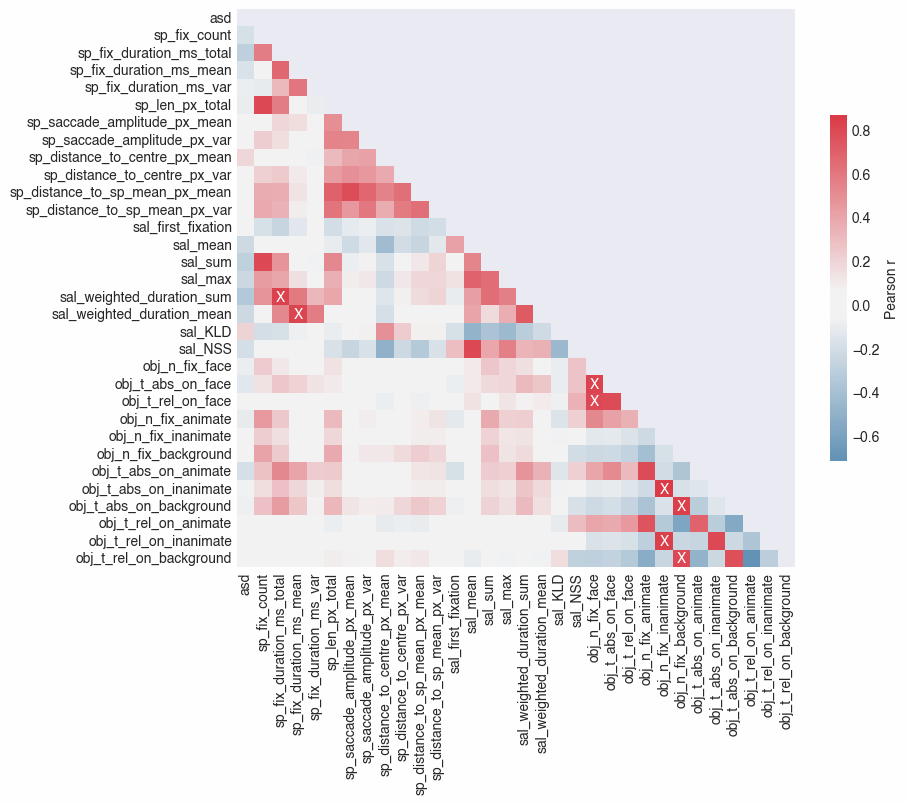

In [4]:
# check for correlations
pp.check_correlations(df[num_cols], thresh=0.8)

### further processing of correlating features
- `sp_fix_duration_ms_total` & `sp_fix_duration_ms_mean`
  - keep the `saliency weighted` version of both fixation duration measures
- `obj_n_fix_*`
  - keep the time measures of object recognition features

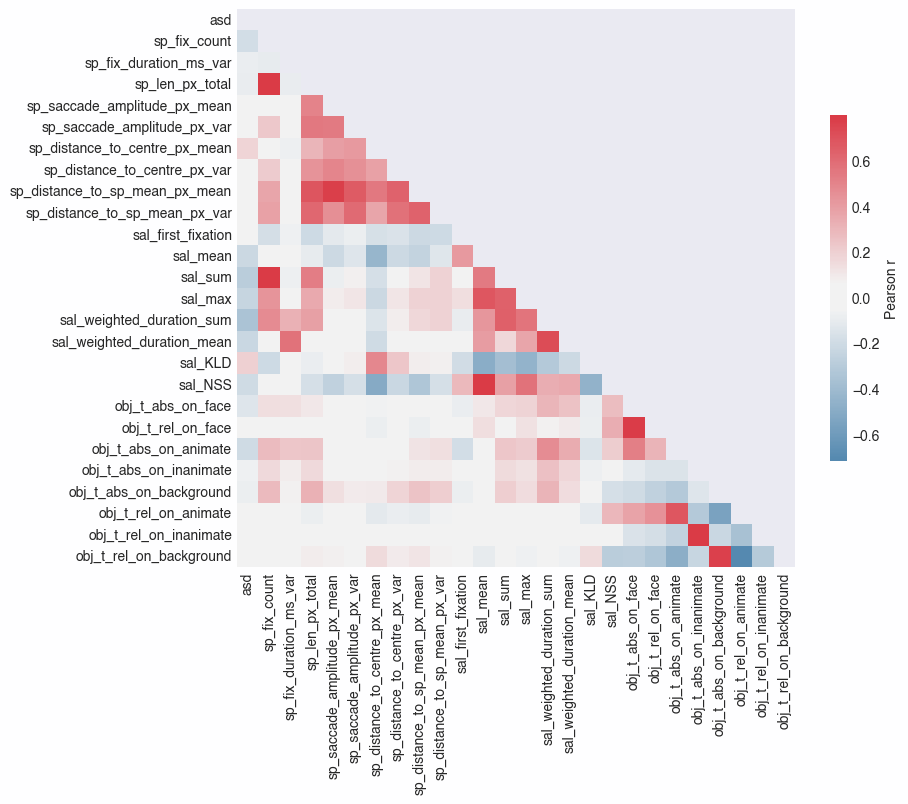

 -> dataframe has 7217 instances and 26 columns
 -> there are 26 numerical columns
 -> there are 0 categoricals columns


In [5]:
# processing
df = df.drop(
    columns=[
        "sp_fix_duration_ms_total",
        "sp_fix_duration_ms_mean",
        "obj_n_fix_face",
        "obj_n_fix_animate",
        "obj_n_fix_inanimate",
        "obj_n_fix_background",
    ]
)

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# check for correlations, again
pp.check_correlations(df[num_cols], thresh=0.8)

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

### Split into train & test sets

As soon as the dataset is in its final form, perform train-test-split with our own split function to have out 30-image-set always as our test set.

In [6]:
# prepare features and target
X = df
y = X.pop("asd")

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6736' samples & '25' features
test-set has '481' samples - out of '7217'
  ~ 6.66% of full dataset


### Set variables

- define `metric`
- behavior for saving models as pickles
- defaults for model-objects

In [7]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 1

---
## Model - Preparations

### Column Transformers for Data Preproccessing
these are only used for certain Models, which we expect to perform better with Preproccessed Data

In [8]:
# add other transformations at the end if needed
transformer = [
    ("scaler", MinMaxScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols),
]

preprocessing = ColumnTransformer(transformer, remainder="passthrough")

###  Pipelines for each Model

In [9]:
# Random Forest: no scaling / no encoding
rf_pipeline = Pipeline([
    ("classifier", RandomForestClassifier())
])

# XGBoost: apply scaling / encoding
xgb_pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", XGBClassifier())
])

# Support Vector Classifier: apply scaling / encoding
svc_pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier",SVC())
])

# Logistic Regression: apply scaling / encoding
log_pipeline = Pipeline([
    ("preprocessor", preprocessing),
    ("classifier", LogisticRegression(max_iter=1000))
])

### Parameter Grids

In [15]:
# Random Forest
param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300, 400, 500],
    "classifier__max_depth": [5, 10, 20, 30, 50],
    "classifier__min_samples_split": [5, 10, 20, 50, 100],
    "classifier__min_samples_leaf": [2, 5, 10, 20],
    "classifier__max_features": ["sqrt", "log2"],
}

# XGBoost
param_grid_xgb = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 7, None],
    "classifier__learning_rate": [0.1, 0.01, 0.001],
}

# Support Vector Classifier
param_grid_svc = {
    "classifier__kernel": ["linear", "poly", "rbf", "sigmoid"],  # Kernel types to try
    "classifier__C": [0.1, 1, 10, 100],  # Regularization parameter values
    "classifier__gamma": ["scale", "auto"],  # Gamma parameter for RBF kernel
    "classifier__degree": [
        2,
        3,
        4,
    ],  # Degree of the polynomial kernel (only for poly kernel)
}

# Logistic Regression
param_grid_log = {
    "classifier__penalty": ["l1", "l2"],  # Penalty type: l1 (Lasso) or l2 (Ridge)
    "classifier__C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Regularization strength
}

---
## Modeling

### Random Forest

#### 1: Full Grid

In [21]:
# grid
param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300, 400, 500],
    "classifier__max_depth": [5, 10, 20, 30, 50],
    "classifier__min_samples_split": [5, 10, 20, 50, 100],
    "classifier__min_samples_leaf": [1, 2, 5, 10, 20],
    "classifier__max_features": ["sqrt", "log2"],
}

# Create GridSearchCV object & fit it
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_rf = grid_search_rf.best_params_
best_est_rf = grid_search_rf.best_estimator_
print("Best params for RF are:", best_params_rf)
print("Best est for RF are:", best_est_rf)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits
Best params for RF are: {'classifier__max_depth': 50, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 20, 'classifier__n_estimators': 400}
Best est for RF are: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=50, max_features='log2',
                                        min_samples_split=20,
                                        n_estimators=400))])


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.917     0.917     0.917      3379
           1      0.917     0.917     0.917      3357

    accuracy                          0.917      6736
   macro avg      0.917     0.917     0.917      6736
weighted avg      0.917     0.917     0.917      6736

f(0.5)-score: 0.917
f(2.0)-score: 0.917

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.705     0.697     0.701       244
           1      0.692     0.700     0.696       237

    accuracy                          0.699       481
   macro avg      0.699     0.699     0.699       481
weighted avg      0.699     0.699     0.699       481

f(0.5)-score: 0.693
f(2.0)-score: 0.699



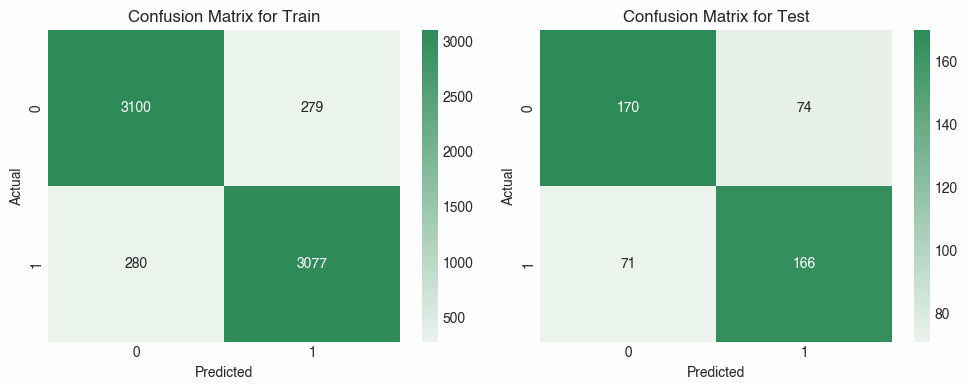

------------------------------------------------------------
'Train': ROC AUC score = 0.917
'Test': ROC AUC score = 0.699


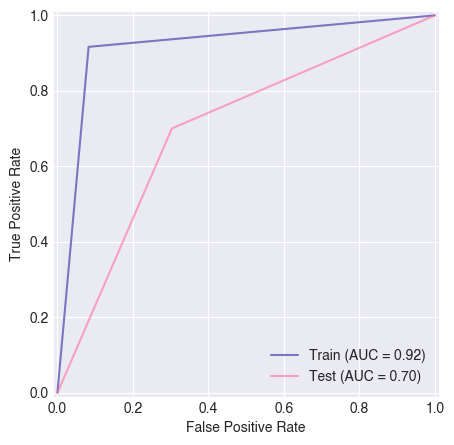

In [25]:
# predict & proba
pred_test = grid_search_rf.predict(X_test)
proba_test = grid_search_rf.predict_proba(X_test)

pred_train = grid_search_rf.predict(X_train)
proba_train = grid_search_rf.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

# learning curves - for one model - f2 score
em.learning(best_est_rf, X_train, y_train)

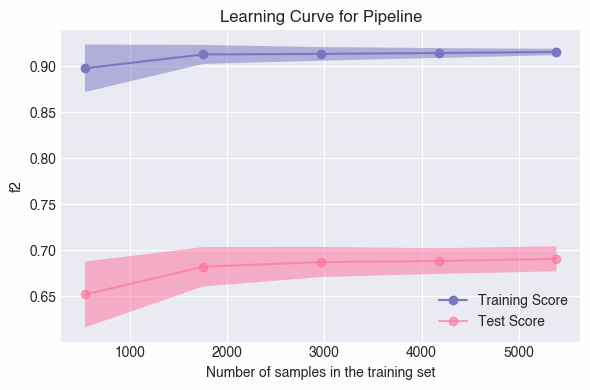

In [24]:
# learning curves - for one model - f2 score
em.learning(best_est_rf, X_train, y_train)

---

#### 2: prune "max_depth" & "min_sample_leafs"

In [26]:
# grid
param_grid_rf = {
    "classifier__n_estimators": [100, 200, 300, 400, 500],
    "classifier__max_depth": [5, 10, 20],
    "classifier__min_samples_split": [5, 10, 20, 50, 100],
    "classifier__min_samples_leaf": [5, 10, 20],
    "classifier__max_features": ["sqrt", "log2"],
}

# Create GridSearchCV object & fit it
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_rf = grid_search_rf.best_params_
best_est_rf = grid_search_rf.best_estimator_
print("Best params for RF are:", best_params_rf)
print("Best est for RF are:", best_est_rf)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


/Users/azabicki/miniconda3/envs/nf_CAPSTONE/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best params for RF are: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}
Best est for RF are: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=10,
                                        min_samples_split=10,
                                        n_estimators=200))])


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.836     0.843     0.839      3379
           1      0.840     0.833     0.837      3357

    accuracy                          0.838      6736
   macro avg      0.838     0.838     0.838      6736
weighted avg      0.838     0.838     0.838      6736

f(0.5)-score: 0.839
f(2.0)-score: 0.835

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.702     0.713     0.707       244
           1      0.700     0.688     0.694       237

    accuracy                          0.701       481
   macro avg      0.701     0.700     0.700       481
weighted avg      0.701     0.701     0.701       481

f(0.5)-score: 0.697
f(2.0)-score: 0.690



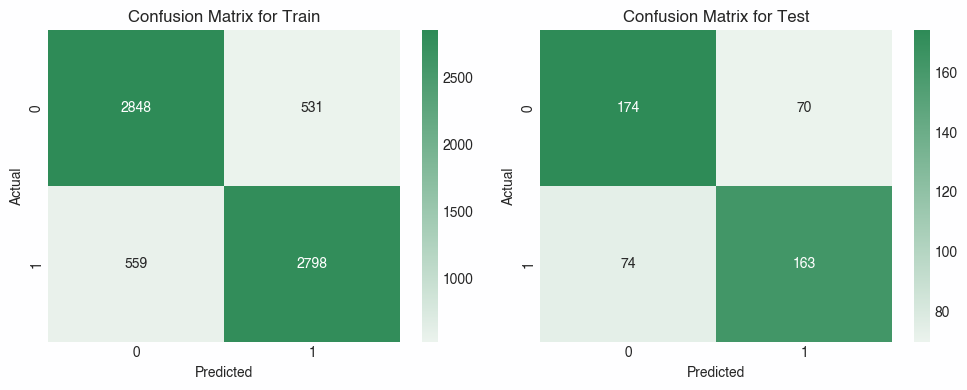

------------------------------------------------------------
'Train': ROC AUC score = 0.838
'Test': ROC AUC score = 0.7


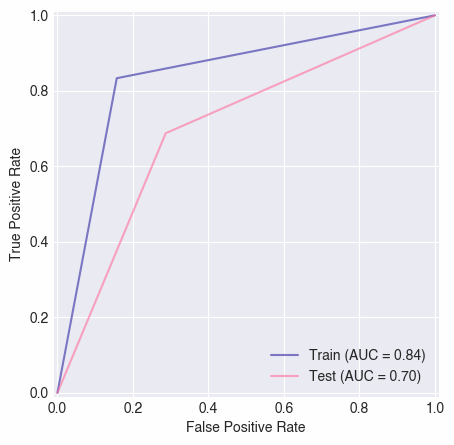

In [27]:
# predict & proba
pred_test = grid_search_rf.predict(X_test)
proba_test = grid_search_rf.predict_proba(X_test)

pred_train = grid_search_rf.predict(X_train)
proba_train = grid_search_rf.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

# learning curves - for one model - f2 score
em.learning(best_est_rf, X_train, y_train)

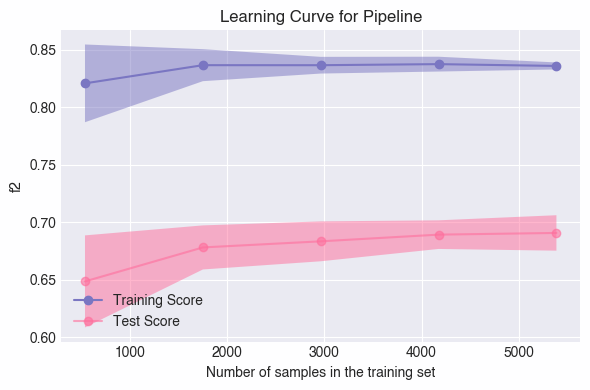

---

#### pruning "min_samples_split" & "max_depth"

In [29]:
# grid
param_grid_rf = {
    "classifier__n_estimators": [200, 300, 400, 500],
    "classifier__max_depth": [5, 10, 15],
    "classifier__min_samples_split": [30, 50, 100],
    "classifier__min_samples_leaf": [5, 10, 20],
    "classifier__max_features": ["sqrt", "log2"],
}

# Create GridSearchCV object & fit it
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
)
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_rf = grid_search_rf.best_params_
best_est_rf = grid_search_rf.best_estimator_
print("Best params for RF are:", best_params_rf)
print("Best est for RF are:", best_est_rf)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/Users/azabicki/miniconda3/envs/nf_CAPSTONE/lib/python3.11/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best params for RF are: {'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 30, 'classifier__n_estimators': 400}
Best est for RF are: Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=15, min_samples_leaf=5,
                                        min_samples_split=30,
                                        n_estimators=400))])


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.828     0.836     0.832      3379
           1      0.833     0.825     0.829      3357

    accuracy                          0.830      6736
   macro avg      0.831     0.830     0.830      6736
weighted avg      0.830     0.830     0.830      6736

f(0.5)-score: 0.832
f(2.0)-score: 0.827

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.698     0.709     0.703       244
           1      0.695     0.684     0.689       237

    accuracy                          0.696       481
   macro avg      0.696     0.696     0.696       481
weighted avg      0.696     0.696     0.696       481

f(0.5)-score: 0.693
f(2.0)-score: 0.686



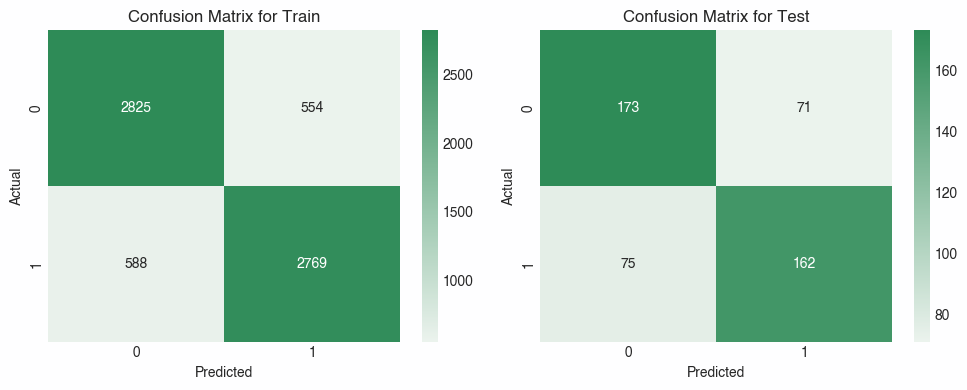

------------------------------------------------------------
'Train': ROC AUC score = 0.83
'Test': ROC AUC score = 0.696


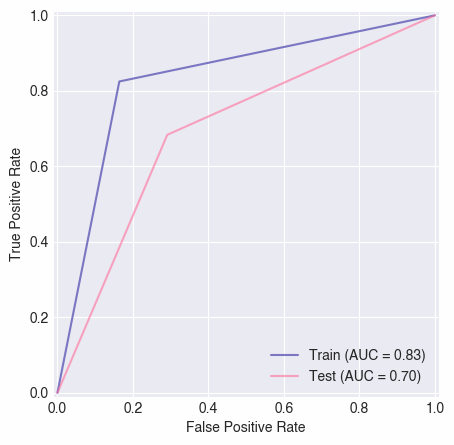

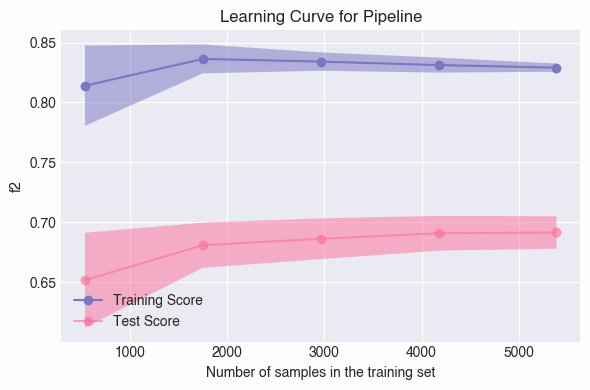

In [30]:
# predict & proba
pred_test = grid_search_rf.predict(X_test)
proba_test = grid_search_rf.predict_proba(X_test)

pred_train = grid_search_rf.predict(X_train)
proba_train = grid_search_rf.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

# learning curves - for one model - f2 score
em.learning(best_est_rf, X_train, y_train)